<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/10_note_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Density Based Clustering Part2

160. Density based clustering validation (DBCV) - part 1
161. Density based clustering validation (DBCV) - part 2
162. Demo: Implementing DBCV from scratch - part 1
163. Demo: Implementing DBCV from scratch - part 2 + DBCV python function
164. DBSCAN general guideliness
165. Demo: Clustering digits (mnist784) with DBSCAN
166. Demo: Clustering animals with DBSCAN (categorical data)
167. HDBSCAN clustering algorithm - part 1
168. HDBSCAN clustering algorithm - part 2
169. HDBSCAN clustering algorithm - part 3

#### DBSCAN 的限制

- `eps` 和 `min_samples` 的最佳值不易找到
- 整個 dataset 使用相同的 `eps` 和 `min_samples` 值, 難以處理不同 density 的 cluster # todo_spencer
  - density threshold 太低: 導致不洽當的 cluster 合併
  - density threshold 太高: 導致多個 cluster 被視為 noise

  <img src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb5a17311-0627-4d14-a52a-5b275df40f94_1982x2062.jpeg"></img>

##### animal zoo dataset (categorical data)

true label:

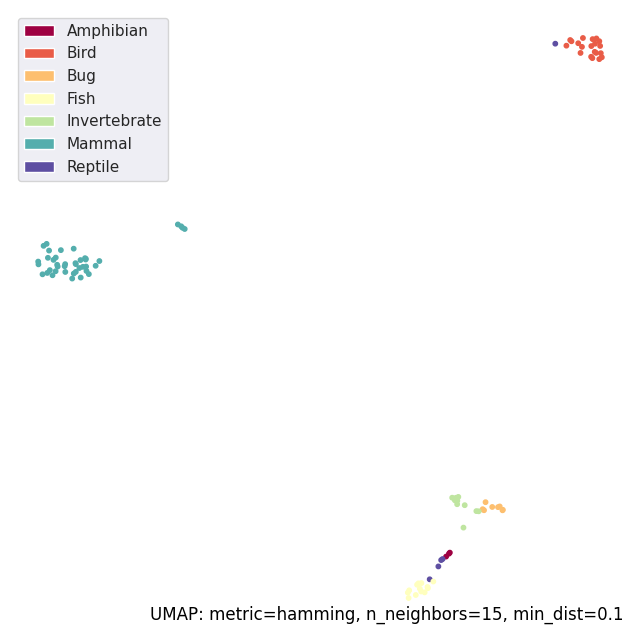

dbscan:

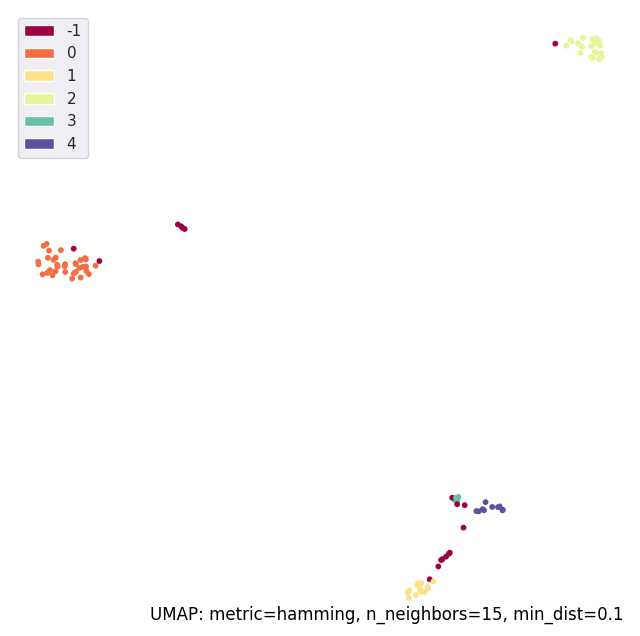

##### mnist dataset

true label:

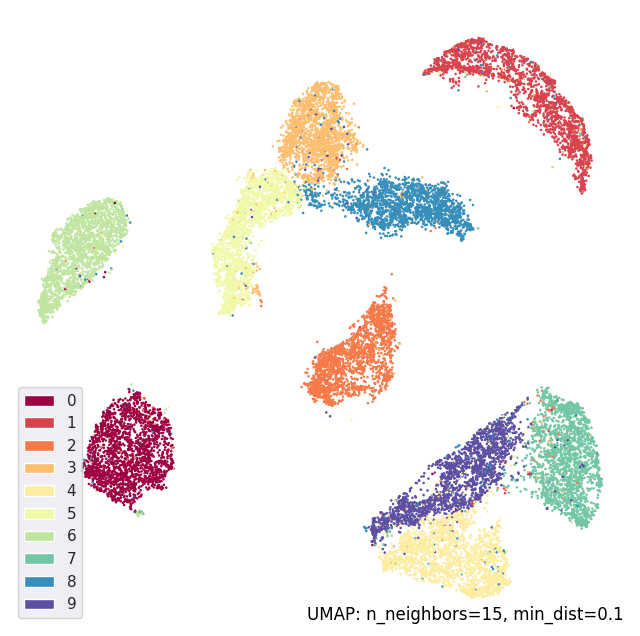

DBSCAN:

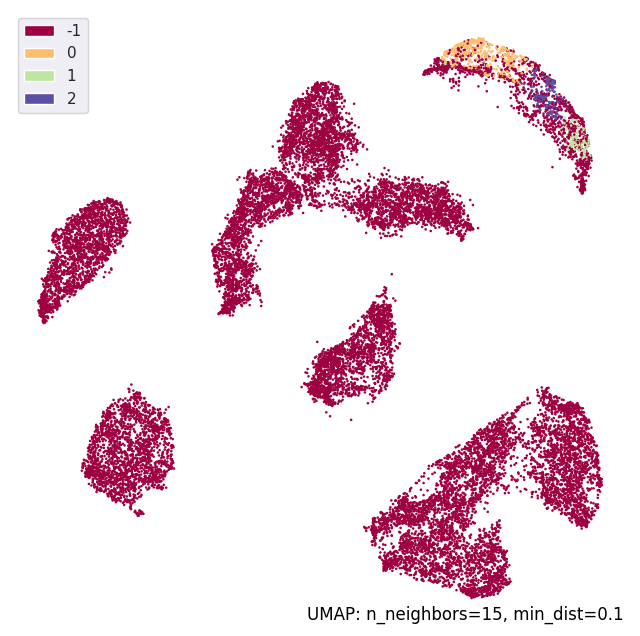

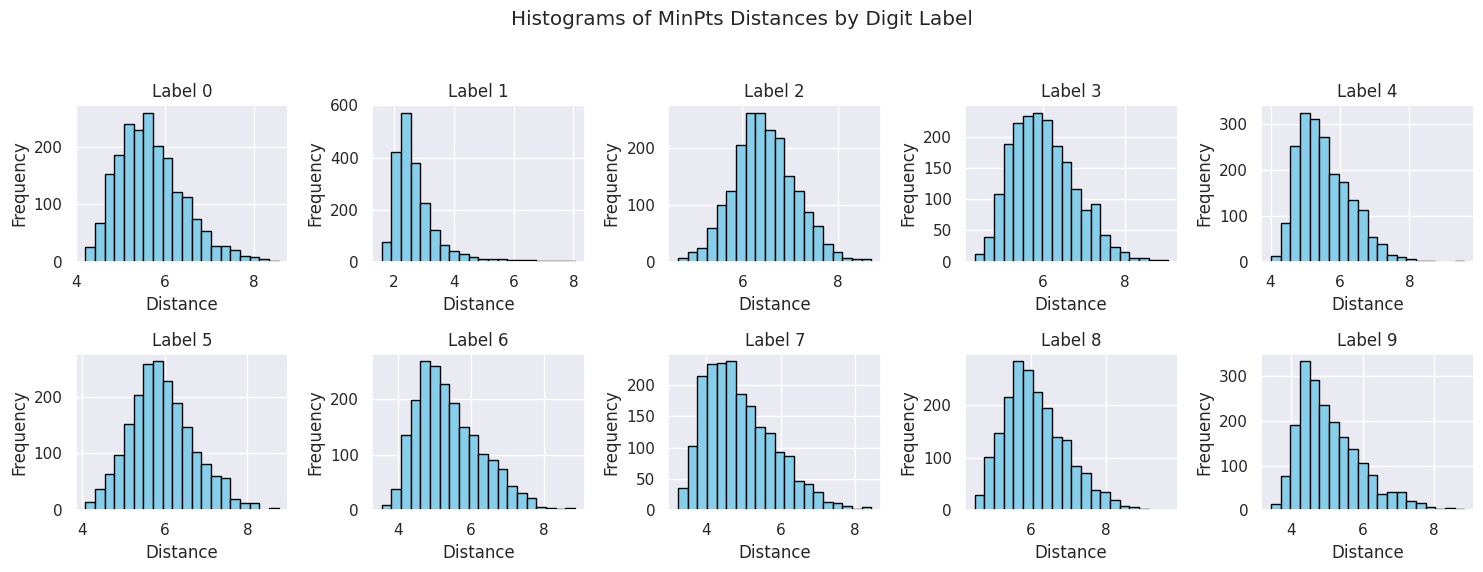

UMAP vs. DensMAP:

<img src='https://umap-learn.readthedocs.io/en/latest/_images/densmap_demo_6_1.png'></img>
<img src='https://umap-learn.readthedocs.io/en/latest/_images/densmap_demo_10_1.png'></img>

[圖源](https://umap-learn.readthedocs.io/en/latest/densmap_demo.html)

效果為何這麼不好 # todo_spencer
```
so we have tried really hard in order to find parameter combination which we can actually use to cluster the data set
but we have failed in every attempt
and the reasons for failing is that in this data set clusters have different densities,
which makes it impossible for DBscan to cluster this data
soon we will learn about DBscan variation, which will be able to perform better with this problem
```

[10_try](https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/10_try.ipynb)

#### HDBSCAN

HDBSCAN (hierarchical density-based spatial clustering of applications with noise)
- hierarchical、density-based clustering 方法
- 產出 density-based clustering hierarchy, 從其中發現 cluster 和 noise

core distances:

$core\_dist(o)=KNN(o, min\_samples)$

- (inverse) density 的估計

mutual reachability distance:

$reach\_dist(i, j)=max(core\_dist(i), core\_dist(j), dist(i, j))$

- 考慮 density 的 point 之間的 symmetric 距離
- reachability distance 小: $i, j$ 的 deisnty 高 && 距離近

mutual reachability graph:
- 以 mutual reachability distance 作為 edge weight 的 fully connected undirected graph

mutual reachability graph minimum spanning tree:
- 描述了 dataset 的 density backbone

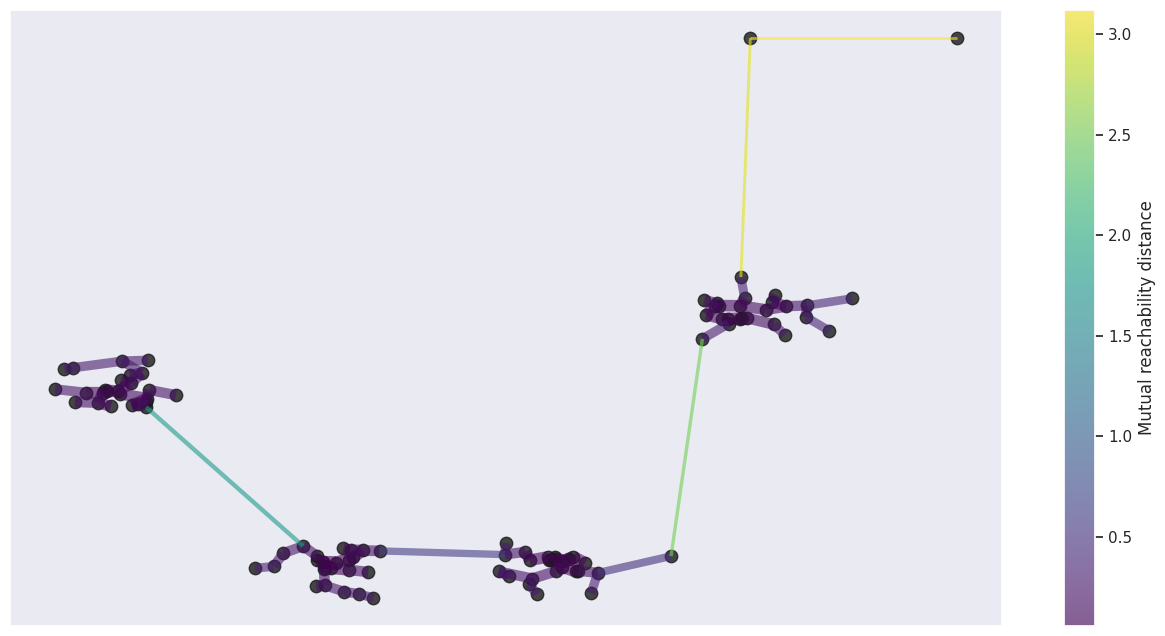

建立 dendrogram:
- 從 MST 的 edge weight (reachability distance) 由小到大 merge node (point) 的所屬 group
    - 等同 (?) 用 single-linkage 來建立 dendrogram

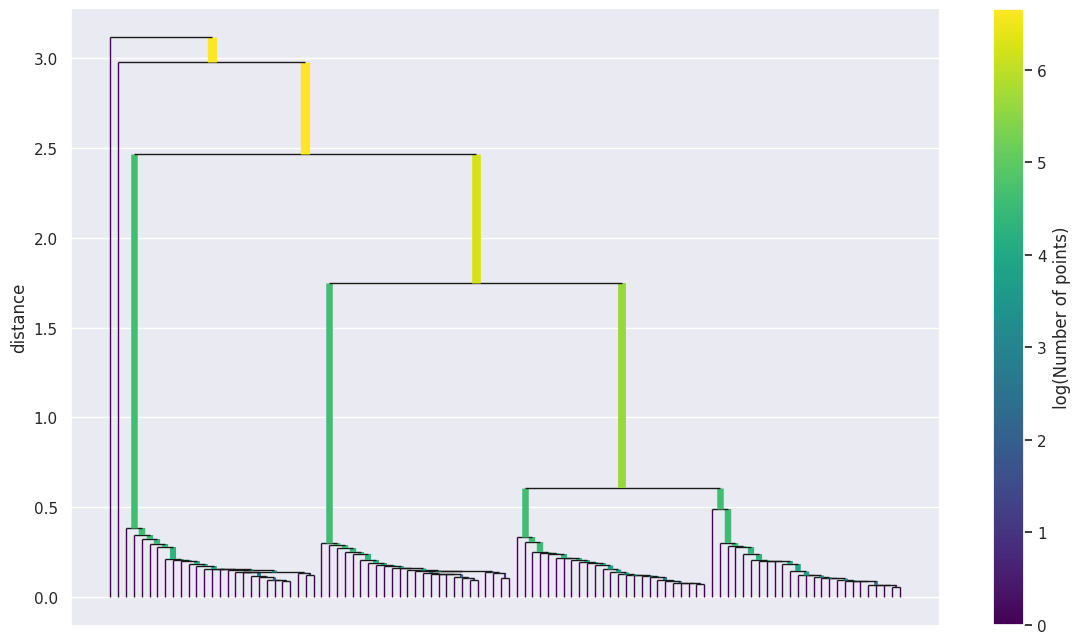

DBSCAN*:
- 只有 core point、noise 的概念
- cluster 為 density level set 的連通部分

在 level `eps` 對 dendrogram 切割得到 clustering (global density threshold)
- 等同 mutual reachability graph 移除 weight > `eps` 的 edge 得到的連通部分
- 等同 parameter 為 `min_samples`、`eps` 的 DBSCAN*
- HDBSCAN 為 hierarchical DBSCAN* # todo_spencer

<pre>
Proposition 1. Let X be a set of n objects described in a metric space by
n×n pairwise distances. The partition of this data obtained by DBSCAN* w.r.t
mpts and ε is identical to the one obtained by first running Single-Linkage over
the transformed space of mutual reachability distances, then, cutting the resulting
dendrogram at level ε of its scale, and treating all resulting singletons with
dcore(xp) > ε as a single class representing “Noise”.
</pre>

<pre>
4.2 Iteratively remove all edges from MSText in decreasing order of weights
(in case of ties, edges must be removed simultaneously):

  4.2.1 Before each removal, set the dendrogram scale value of the current
  hierarchical level as the weight of the edge(s) to be removed.
  
  4.2.2 After each removal, assign labels to the connected component(s)
  that contain(s) the end vertex(-ices) of the removed edge(s), to obtain
  the next hierarchical level: assign a new cluster label to a component if
  it still has at least one edge, else assign it a null label (“noise”).
</pre>

condensed tree:
- 由上往下, 對每個 split node
  - 若兩個 branch 的 point 數目都 > `min_cluster_size`, 則維持拆分的 branch
  - 否則壓縮顯示為一個隨 density 的增加, 有 point leaking 的 cluster
  - 寬度代表 point, 長度的尾端表示該 point 的 leakage event

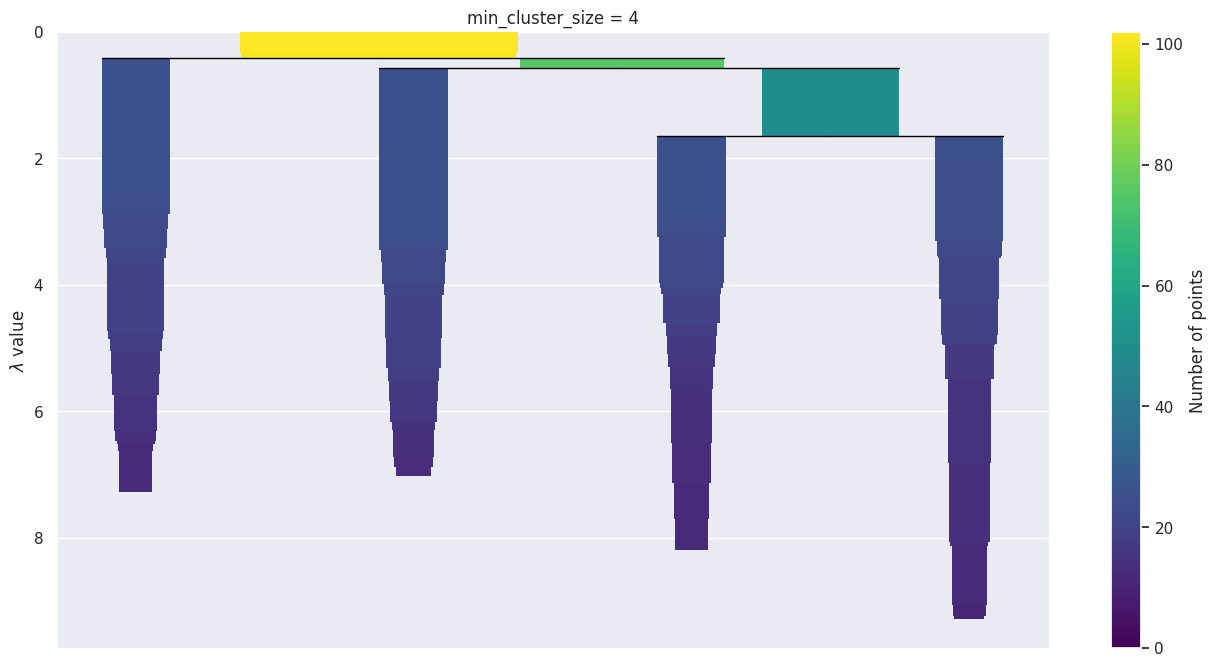

- $\lambda=1/distance$: density 的估計
- $\lambda_{birth}$: branch 開始的 $\lambda$
- $\lambda_{death}$: branch 結束的 $\lambda$
- $\lambda_{p}$: point 的 leakage event 發生的 $\lambda$

cluster stability:
- $\sum_{p \in cluster} (\lambda_p-\lambda_{birth})$
- 對應 branch 的面積, 面積較高代表該 cluster 在 density 增加的很大範圍內持續存在, 較為穩定

excess of mass:
- leaf 標記為 cluster
- 由下往上, 對每個 split node
  - 如果 child cluster 的 stability sum > split node 的 stability, 則 child branch 標記為 cluster
  - 否則 split node 標記為 cluster, child cluster 取消 cluster 標記
- 最後有標記的 cluster 為最穩定的 clustering

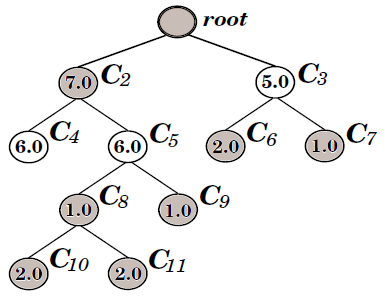

by paper

leaf method:
- leaf 形成 cluster

`cluster_selection_epsilon`:
- 若兩個 branch 的 distance < 此值, 則視為一個 cluster

parameters:
- `min_samples`: 計算 core distance
- `min_cluster_size`: 建構 condensed tree 時用到

hdbscan 如何區分 noise # todo_spencer

<pre>
With a minimum cluster size, mclSize ≥ 1, components with fewer
than mclSize objects are disregarded, and their disconnection from a cluster does
not establish a “true” split. We can adapt HDBSCAN accordingly by changing
Step 4.2.2 of Algorithm 1 as shown in Algorithm 2: a connected component is
deemed spurious if it has fewer than mclSize objects or, for mclSize = 1, if it
is an isolated, non-dense object (no edges). Any spurious component is labeled
as noise and its removal from a bigger component is not considered as a cluster
split. In practice, this can reduce the size of the hierarchy dramatically.
</pre>

<pre>
4.2.2 After each removal (to obtain the next hierarchical level), process one at a
time each cluster that contained the edge(s) just removed, by relabeling its
resulting connected subcomponent(s):

  Label spurious subcomponents as noise by assigning them the null label. If all
  subcomponents of a cluster are spurious, then the cluster has disappeared.

  Else, if a single subcomponent of a cluster is not spurious, keep its original
  cluster label (cluster has just shrunk).

  Else, if two or more subcomponents of a cluster are not spurious, assign new
  cluster labels to each of them (“true” cluster split).
</pre>

#### Density based clustering validation (DBCV)

core distance:

$\LARGE core\_dist(o)=\left(\frac{\sum_{i=2}^{n_i}\left(\frac{1}{dist(o, i)}\right)^d}{n_i-1}\right)^{-\frac{1}{d}}$

- (inverse) density 的估計
- 鄰近 cluster point 的貢獻較大
- 可與距離比較
  - $KNN(o, 2) \le core\_dist(o) \le KNN(o, n)$

mutual reachability distance:

$reach\_dist(i, j)=max(core\_dist(i), core\_dist(j), dist(i, j))$

- 考慮 density 的 point 之間的 symmetric 距離
- reachability distance 小: $i, j$ 的 deisnty 高 && 距離近

mutual reachability graph:
- 針對每個 cluster, 以 mutual reachability distance 作為 edge weight 的 fully connected undirected graph

mutual reachability graph minimum spanning tree:
- 捕捉了 cluster 的 connectivity (形狀、density)
- internal node: degree > 1
- internal edge: 端點不是 internal node
- internal edge 描述了 cluster 的主幹

cluster density sparseness:
- 針對每個 cluster, 計算 MST 中 internal edge 的最大 weight
- cluster 內最低 density 的區域

cluster density separation:
- $density\_separation(C_i, C_j)$: cluster $C_i$ 和 $C_j$ 的 MST 的 internal node 間的最小 reachability distance
  - cluster $C_i$ 和 $C_j$ 間最高 density 的區域
- 針對每個 cluster $C_i$, 計算 $\min_{1 \le j \le k, j \neq i} density\_separation(C_i, C_j)$ (max??min??) # todo_spencer
```
choose maximum value across clusters and consider it a cluster density separation
```

<font size='4'>


```python
min_density_sep = density_sep[i].min()
cluster_validity_indices[i] = (
  (min_density_sep - density_sparseness[i]) /
  max(min_density_sep, density_sparseness[i])
) # 看程式碼也是取 min
```

</font>

cluster validation coefficient:

$\Large clust\_val\_coef=\frac{clust\_density\_separation-clust\_density\_sparseness}{max(clust\_density\_separation, clust\_density\_sparseness)}$
- range: $[-1, 1]$

DBCV:

$\Large \sum_{i}\left(\frac{number\_of\_points\_in\_cluster_j}{total\_number\_of\_points} \times cluster\_validation\_coef_i\right)$
- range: $[-1, 1]$

##### vs. silhouette score # todo_spencer

$\Large s(p)=\frac{b(p)-a(p)}{max\{b(p), a(p)\}}$
- $b(p)$: 與其他 cluster 內的點的最小平均距離
- $a(p)$: 與相同 cluster 內的點的平均距離

#### API - DBCV

[api](https://hdbscan.readthedocs.io/en/latest/api.html#hdbscan.validity.validity_index)

<font size='4'>


```python
hdbscan.validity.validity_index(X, labels, metric='euclidean', d=None,
  per_cluster_scores=False, mst_raw_dist=False, verbose=False, **kwd_args)
```

</font>

- `d`: `metric='precomputed'` 時, 界定 feature 的個數
- `mst_raw_dist=True`: reachability distance 等同 raw distance # todo_spencer
  - 這在彼此靠近的細長 cluster 情況下特別有利 (可能因為此情況下, 用距離算會比用 core distance 算差異更大, 分數更高)


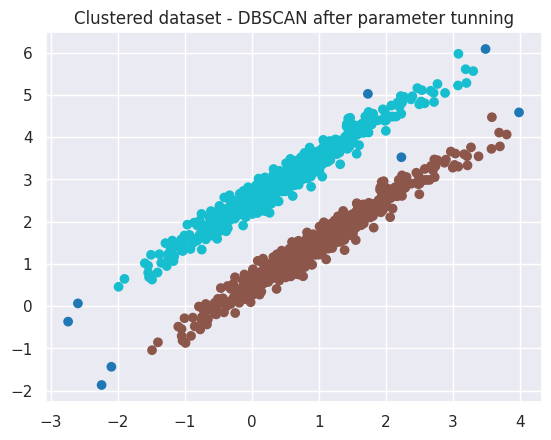

<font size='4'>

```python
hdbscan.validity.validity_index(X, dbscan_tun.labels_, metric='euclidean', per_cluster_scores=True, verbose=True)
# Max raw distance to coredistance ratio: 22.17052374110553
# Max raw distance to coredistance ratio: 22.170523741108383
# Minimum density separation: 1.0249826873382522
# Density sparseness: 0.7874959623939191
# Minimum density separation: 1.0249826873382522
# Density sparseness: 0.7874959623939275
# (0.22984469304214578, array([0.23169828, 0.23169828]))

hdbscan.validity.validity_index(X, kmeans.labels_, metric='euclidean', per_cluster_scores=True, verbose=True)
# Max raw distance to coredistance ratio: 20.44588331986597
# Max raw distance to coredistance ratio: 23.51485242576479
# Minimum density separation: 0.2067658584497767
# Density sparseness: 1.9978799006622636
# Minimum density separation: 0.2067658584497767
# Density sparseness: 0.808723051869442
# (-0.8115926459449254, array([-0.89650736, -0.74433045]))

hdbscan.validity.validity_index(X, dbscan_tun.labels_, metric='euclidean', per_cluster_scores=True,
  mst_raw_dist=True, verbose=True)
# Minimum density separation: 0.8922348258276525
# Density sparseness: 0.369836740380324
# Minimum density separation: 0.8922348258276525
# Density sparseness: 0.369836740380324
# (0.5808099905571843, array([0.58549394, 0.58549394]))

hdbscan.validity.validity_index(X, kmeans.labels_, metric='euclidean', per_cluster_scores=True,
  mst_raw_dist=True, verbose=True)
# Minimum density separation: 0.03904329428456248
# Density sparseness: 0.6658434757898748
# Minimum density separation: 0.03904329428456248
# Density sparseness: 0.725360396299077
# (-0.9440473499857474, array([-0.94136265, -0.94617394]))

```

</font>